# 📢 Análisis de Sentimiento - Consumer Complaint Database (CFPB)

Análisis de polaridad usando VADER y TextBlob, comparación por productos y canales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Usar new_df ya preparado
new_df = pd.read_csv('new_dataset.csv')
print(f"Dataset: {len(new_df):,} registros")
print(f"Narrativas disponibles: {new_df['consumer_complaint_narrative'].notna().sum():,}")

Dataset: 8,509,423 registros
Narrativas disponibles: 2,715,202


## 1. Preparación de Datos para Análisis de Sentimiento

In [3]:
# Filtrar registros con narrativa
sentiment_df = new_df[new_df['consumer_complaint_narrative'].notna()].copy()

# Tomar muestra para análisis eficiente
sample_size = min(15000, len(sentiment_df))
sentiment_sample = sentiment_df.sample(n=sample_size, random_state=42)

print(f"Muestra para análisis de sentimiento: {len(sentiment_sample):,}")

Muestra para análisis de sentimiento: 15,000


## 2. Análisis de Sentimiento con VADER y TextBlob

In [4]:
# Inicializar analizadores
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """Obtener sentimiento VADER"""
    if pd.isna(text):
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    return analyzer.polarity_scores(str(text))

def get_textblob_sentiment(text):
    """Obtener sentimiento TextBlob"""
    if pd.isna(text):
        return {'polarity': 0, 'subjectivity': 0}
    blob = TextBlob(str(text))
    return {'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity}

print("Calculando sentimientos...")

# VADER sentiment
vader_results = sentiment_sample['consumer_complaint_narrative'].apply(get_vader_sentiment)
sentiment_sample['vader_compound'] = [r['compound'] for r in vader_results]
sentiment_sample['vader_pos'] = [r['pos'] for r in vader_results]
sentiment_sample['vader_neg'] = [r['neg'] for r in vader_results]
sentiment_sample['vader_neu'] = [r['neu'] for r in vader_results]

# TextBlob sentiment
textblob_results = sentiment_sample['consumer_complaint_narrative'].apply(get_textblob_sentiment)
sentiment_sample['textblob_polarity'] = [r['polarity'] for r in textblob_results]
sentiment_sample['textblob_subjectivity'] = [r['subjectivity'] for r in textblob_results]

print("Análisis de sentimiento completado!")

Calculando sentimientos...
Análisis de sentimiento completado!


In [5]:
# Estadísticas descriptivas de sentimiento
print("📊 ESTADÍSTICAS DE SENTIMIENTO:")
print("\nVADER Compound Score:")
print(f"Media: {sentiment_sample['vader_compound'].mean():.3f}")
print(f"Mediana: {sentiment_sample['vader_compound'].median():.3f}")
print(f"Desv. Estándar: {sentiment_sample['vader_compound'].std():.3f}")

print("\nTextBlob Polarity:")
print(f"Media: {sentiment_sample['textblob_polarity'].mean():.3f}")
print(f"Mediana: {sentiment_sample['textblob_polarity'].median():.3f}")
print(f"Desv. Estándar: {sentiment_sample['textblob_polarity'].std():.3f}")

📊 ESTADÍSTICAS DE SENTIMIENTO:

VADER Compound Score:
Media: -0.026
Mediana: 0.000
Desv. Estándar: 0.674

TextBlob Polarity:
Media: 0.013
Mediana: 0.000
Desv. Estándar: 0.174


## 3. Distribución de Sentimientos

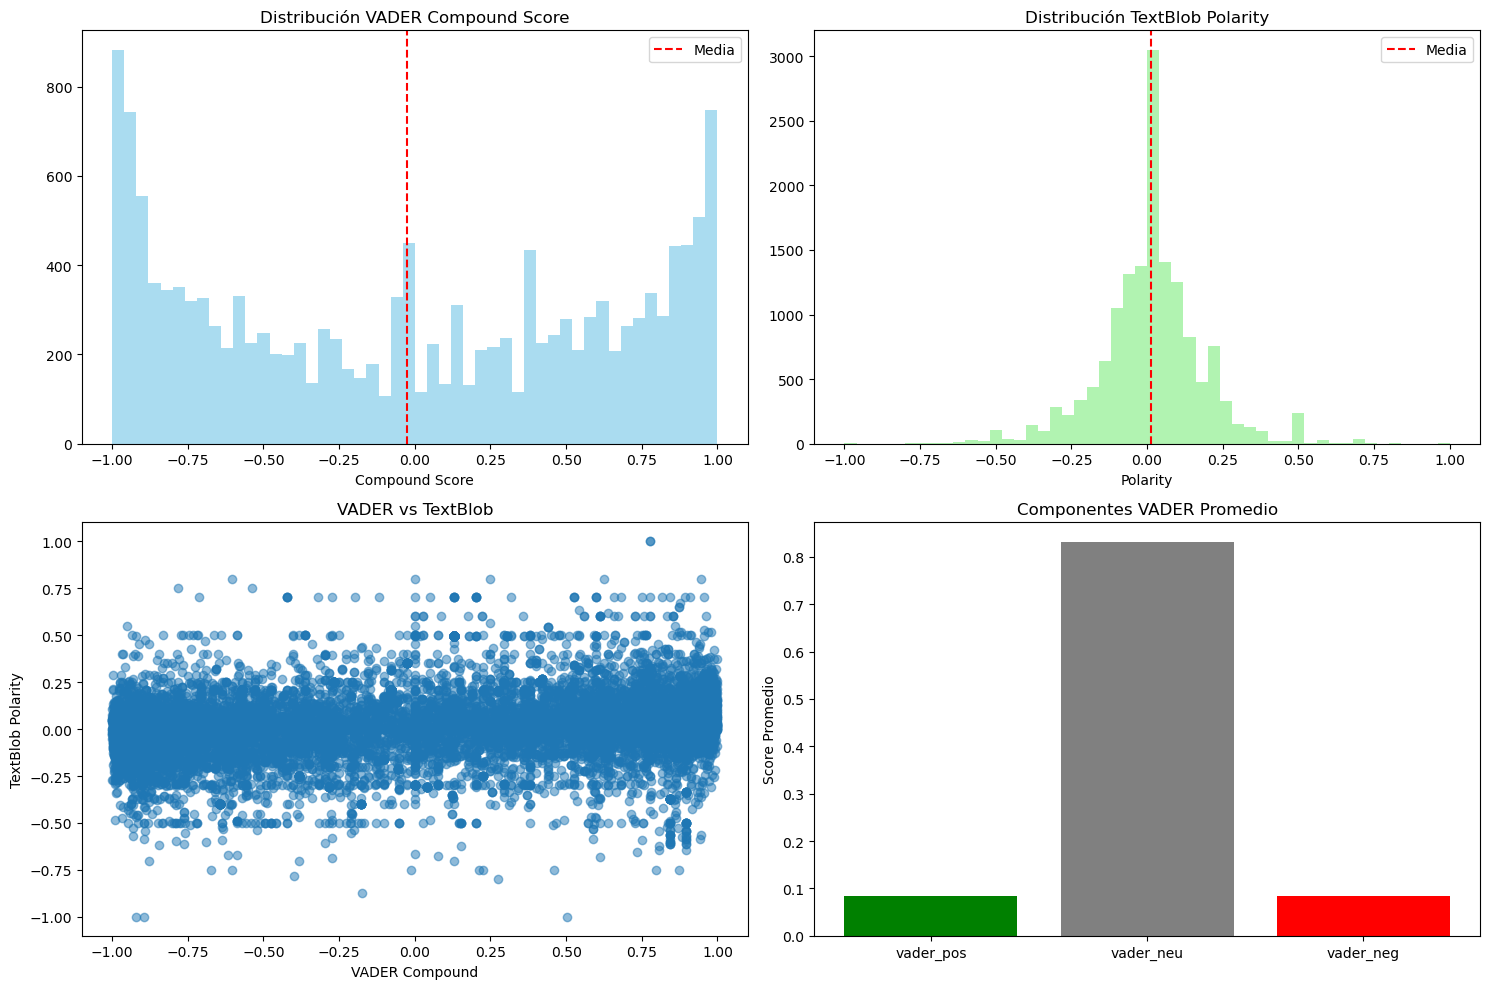

In [6]:
# Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# VADER Compound
axes[0,0].hist(sentiment_sample['vader_compound'], bins=50, alpha=0.7, color='skyblue')
axes[0,0].axvline(sentiment_sample['vader_compound'].mean(), color='red', linestyle='--', label='Media')
axes[0,0].set_title('Distribución VADER Compound Score')
axes[0,0].set_xlabel('Compound Score')
axes[0,0].legend()

# TextBlob Polarity
axes[0,1].hist(sentiment_sample['textblob_polarity'], bins=50, alpha=0.7, color='lightgreen')
axes[0,1].axvline(sentiment_sample['textblob_polarity'].mean(), color='red', linestyle='--', label='Media')
axes[0,1].set_title('Distribución TextBlob Polarity')
axes[0,1].set_xlabel('Polarity')
axes[0,1].legend()

# Comparación VADER vs TextBlob
axes[1,0].scatter(sentiment_sample['vader_compound'], sentiment_sample['textblob_polarity'], alpha=0.5)
axes[1,0].set_xlabel('VADER Compound')
axes[1,0].set_ylabel('TextBlob Polarity')
axes[1,0].set_title('VADER vs TextBlob')

# Componentes VADER
vader_components = sentiment_sample[['vader_pos', 'vader_neu', 'vader_neg']].mean()
axes[1,1].bar(vader_components.index, vader_components.values, color=['green', 'gray', 'red'])
axes[1,1].set_title('Componentes VADER Promedio')
axes[1,1].set_ylabel('Score Promedio')

plt.tight_layout()
plt.show()

## 4. Productos con Quejas Más Negativas

In [7]:
# Análisis por producto
product_sentiment = sentiment_sample.groupby('product').agg({
    'vader_compound': ['mean', 'count'],
    'textblob_polarity': 'mean'
}).round(3)

product_sentiment.columns = ['vader_mean', 'count', 'textblob_mean']
product_sentiment = product_sentiment[product_sentiment['count'] >= 50]  # Mín 50 quejas
product_sentiment = product_sentiment.sort_values('vader_mean')

print("🔻 TOP 10 PRODUCTOS CON QUEJAS MÁS NEGATIVAS (VADER):")
top_negative = product_sentiment.head(10)
for i, (product, row) in enumerate(top_negative.iterrows(), 1):
    print(f"{i:2d}. {product[:50]}...")
    print(f"    VADER: {row['vader_mean']:.3f} | TextBlob: {row['textblob_mean']:.3f} | Quejas: {row['count']}")

print("\n🔺 TOP 5 PRODUCTOS CON QUEJAS MENOS NEGATIVAS:")
top_positive = product_sentiment.tail(5)
for i, (product, row) in enumerate(top_positive.iterrows(), 1):
    print(f"{i}. {product[:50]}...")
    print(f"   VADER: {row['vader_mean']:.3f} | TextBlob: {row['textblob_mean']:.3f} | Quejas: {row['count']}")

🔻 TOP 10 PRODUCTOS CON QUEJAS MÁS NEGATIVAS (VADER):
 1. Money transfer, virtual currency, or money service...
    VADER: -0.540 | TextBlob: -0.021 | Quejas: 497.0
 2. Checking or savings account...
    VADER: -0.307 | TextBlob: 0.003 | Quejas: 775.0
 3. Debt collection...
    VADER: -0.188 | TextBlob: 0.019 | Quejas: 1729.0
 4. Bank account or service...
    VADER: -0.165 | TextBlob: 0.019 | Quejas: 89.0
 5. Consumer Loan...
    VADER: -0.058 | TextBlob: -0.007 | Quejas: 67.0
 6. Mortgage...
    VADER: -0.053 | TextBlob: 0.006 | Quejas: 740.0
 7. Vehicle loan or lease...
    VADER: -0.017 | TextBlob: 0.000 | Quejas: 200.0
 8. Credit card or prepaid card...
    VADER: 0.041 | TextBlob: -0.001 | Quejas: 604.0
 9. Credit reporting or other personal consumer report...
    VADER: 0.041 | TextBlob: 0.021 | Quejas: 4834.0
10. Credit reporting...
    VADER: 0.046 | TextBlob: -0.008 | Quejas: 174.0

🔺 TOP 5 PRODUCTOS CON QUEJAS MENOS NEGATIVAS:
1. Credit reporting...
   VADER: 0.046 | TextBlob

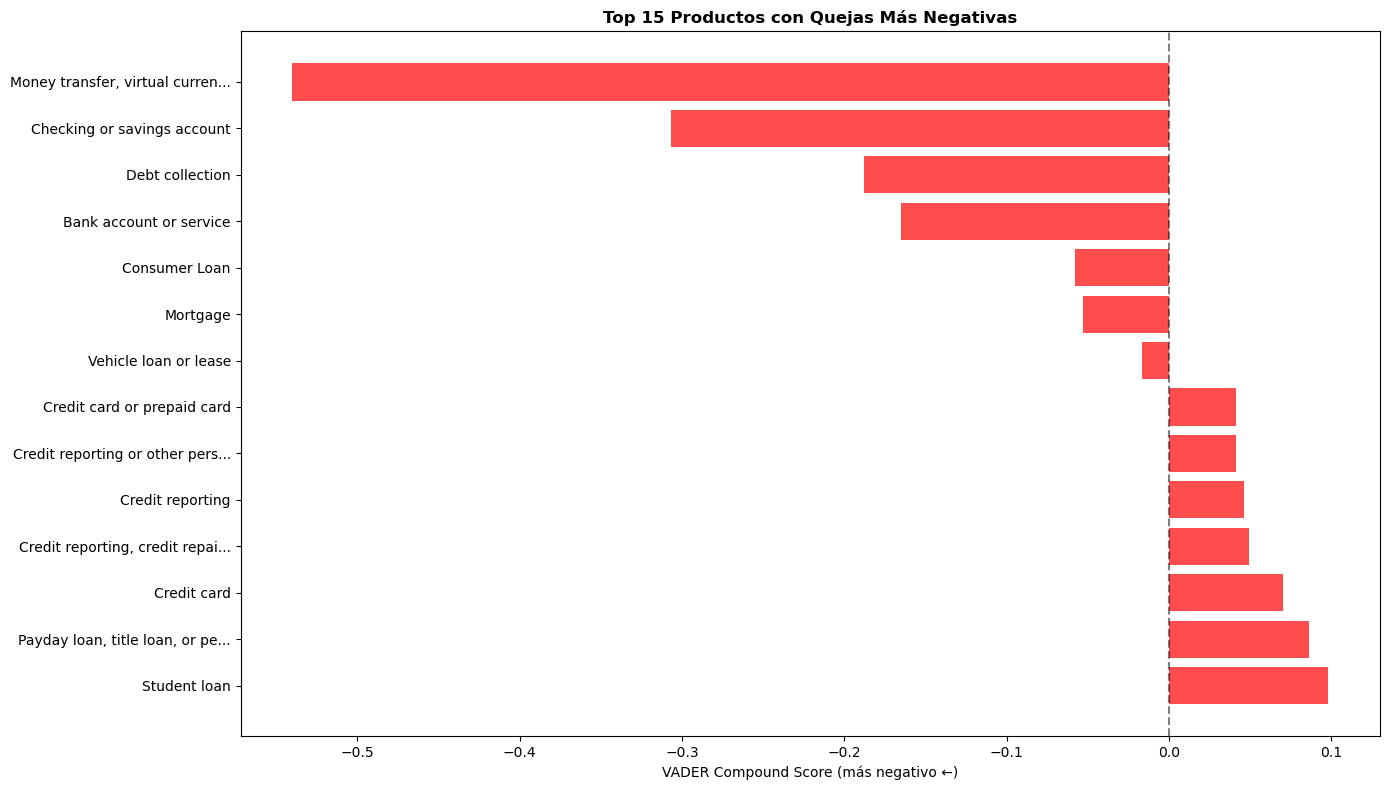

In [8]:
# Visualización de productos más negativos
plt.figure(figsize=(14, 8))
top_15_negative = product_sentiment.head(15)
product_names = [p[:30] + '...' if len(p) > 30 else p for p in top_15_negative.index]

plt.barh(range(len(product_names)), top_15_negative['vader_mean'], color='red', alpha=0.7)
plt.yticks(range(len(product_names)), product_names)
plt.xlabel('VADER Compound Score (más negativo ←)')
plt.title('Top 15 Productos con Quejas Más Negativas', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Sentimiento vs Respuesta de la Empresa

📋 SENTIMIENTO POR RESPUESTA DE LA EMPRESA:
• Closed with monetary relief:
  VADER: -0.168 | TextBlob: 0.005 | Casos: 410.0
• Closed with explanation:
  VADER: -0.046 | TextBlob: 0.011 | Casos: 9997.0
• Closed with non-monetary relief:
  VADER: 0.032 | TextBlob: 0.017 | Casos: 4467.0


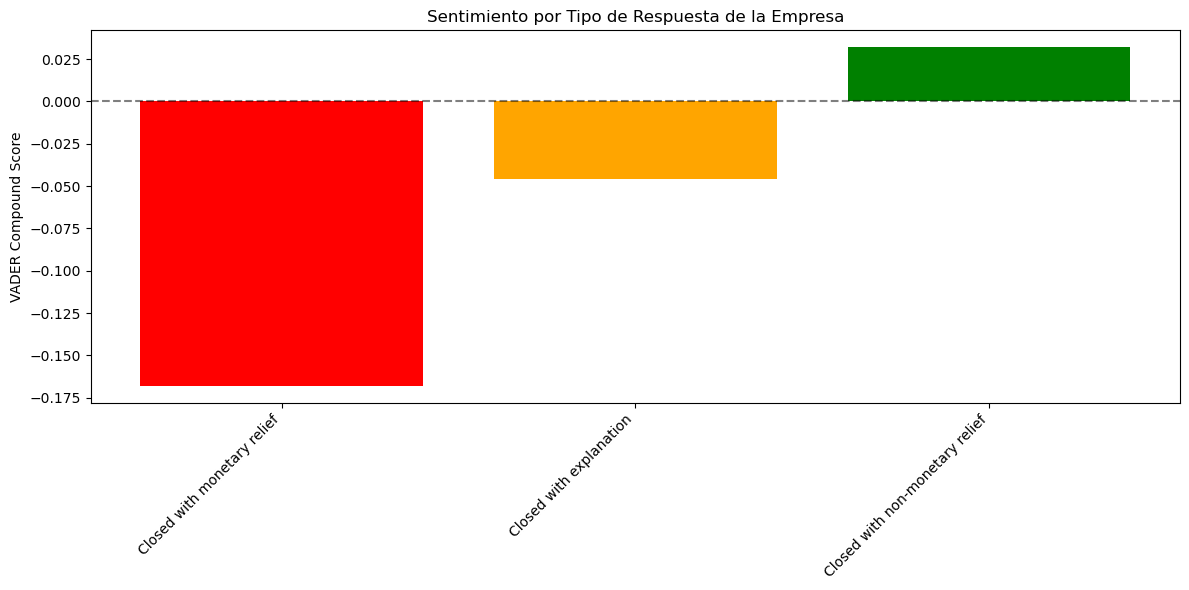

In [9]:
# Análisis por respuesta de la empresa
response_sentiment = sentiment_sample.groupby('company_response_to_consumer').agg({
    'vader_compound': ['mean', 'count'],
    'textblob_polarity': 'mean'
}).round(3)

response_sentiment.columns = ['vader_mean', 'count', 'textblob_mean']
response_sentiment = response_sentiment[response_sentiment['count'] >= 100]
response_sentiment = response_sentiment.sort_values('vader_mean')

print("📋 SENTIMIENTO POR RESPUESTA DE LA EMPRESA:")
for response, row in response_sentiment.iterrows():
    print(f"• {response}:")
    print(f"  VADER: {row['vader_mean']:.3f} | TextBlob: {row['textblob_mean']:.3f} | Casos: {row['count']}")

# Visualización
plt.figure(figsize=(12, 6))
plt.bar(range(len(response_sentiment)), response_sentiment['vader_mean'], 
        color=['red' if x < -0.1 else 'orange' if x < 0 else 'green' for x in response_sentiment['vader_mean']])
plt.xticks(range(len(response_sentiment)), response_sentiment.index, rotation=45, ha='right')
plt.ylabel('VADER Compound Score')
plt.title('Sentimiento por Tipo de Respuesta de la Empresa')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 6. Sentimiento vs Canal de Envío

📱 SENTIMIENTO POR CANAL DE ENVÍO:
• Web: VADER -0.026 | TextBlob 0.013 | Casos: 15000.0


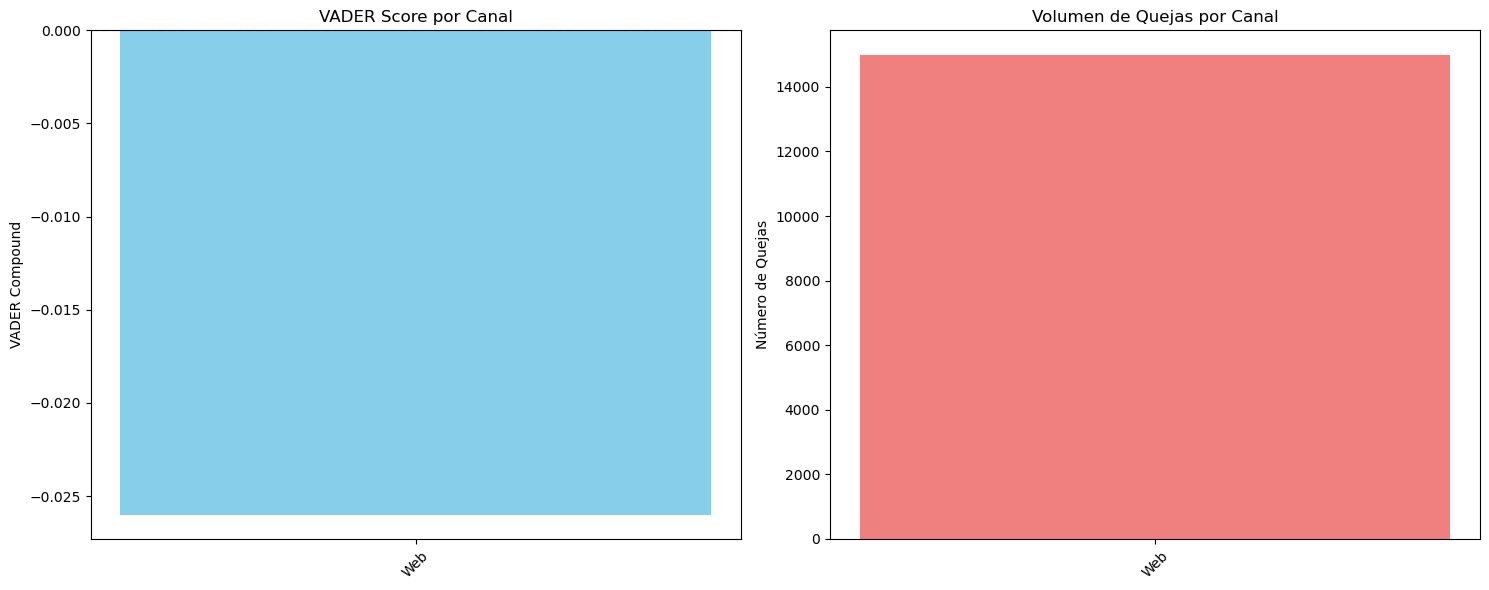

In [10]:
# Análisis por canal de envío
channel_sentiment = sentiment_sample.groupby('submitted_via').agg({
    'vader_compound': ['mean', 'count'],
    'textblob_polarity': 'mean'
}).round(3)

channel_sentiment.columns = ['vader_mean', 'count', 'textblob_mean']
channel_sentiment = channel_sentiment.sort_values('vader_mean')

print("📱 SENTIMIENTO POR CANAL DE ENVÍO:")
for channel, row in channel_sentiment.iterrows():
    print(f"• {channel}: VADER {row['vader_mean']:.3f} | TextBlob {row['textblob_mean']:.3f} | Casos: {row['count']}")

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# VADER por canal
ax1.bar(channel_sentiment.index, channel_sentiment['vader_mean'], color='skyblue')
ax1.set_title('VADER Score por Canal')
ax1.set_ylabel('VADER Compound')
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Volumen por canal
ax2.bar(channel_sentiment.index, channel_sentiment['count'], color='lightcoral')
ax2.set_title('Volumen de Quejas por Canal')
ax2.set_ylabel('Número de Quejas')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 7. Análisis de Correlaciones

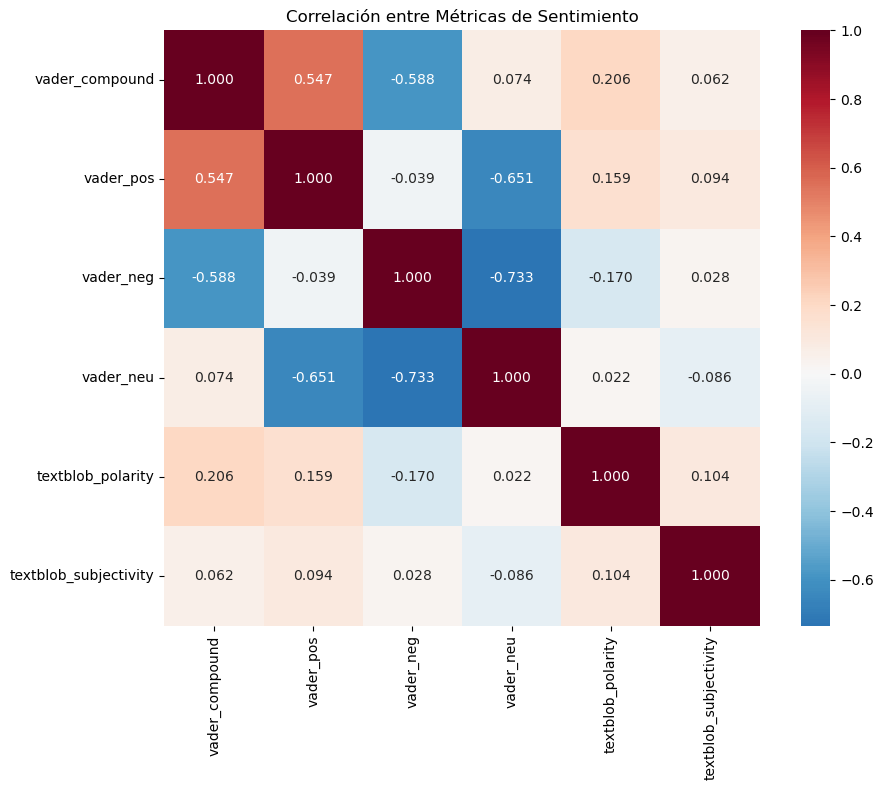

Correlación VADER-TextBlob: 0.206


In [11]:
# Correlación entre métricas de sentimiento
sentiment_cols = ['vader_compound', 'vader_pos', 'vader_neg', 'vader_neu', 
                 'textblob_polarity', 'textblob_subjectivity']
correlation_matrix = sentiment_sample[sentiment_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f')
plt.title('Correlación entre Métricas de Sentimiento')
plt.tight_layout()
plt.show()

print(f"Correlación VADER-TextBlob: {sentiment_sample['vader_compound'].corr(sentiment_sample['textblob_polarity']):.3f}")

## 8. Ejemplos de Quejas por Sentimiento

In [12]:
# Ejemplos de quejas más negativas y menos negativas
most_negative = sentiment_sample.nsmallest(3, 'vader_compound')
least_negative = sentiment_sample.nlargest(3, 'vader_compound')

print("😡 EJEMPLOS DE QUEJAS MÁS NEGATIVAS:")
print("=" * 50)
for i, (_, row) in enumerate(most_negative.iterrows(), 1):
    print(f"\n{i}. VADER: {row['vader_compound']:.3f} | TextBlob: {row['textblob_polarity']:.3f}")
    print(f"producto: {row['product'][:50]}...")
    print(f"narrativa: {row['consumer_complaint_narrative'][:200]}...")

print("\n\n😐 EJEMPLOS DE QUEJAS MENOS NEGATIVAS:")
print("=" * 50)
for i, (_, row) in enumerate(least_negative.iterrows(), 1):
    print(f"\n{i}. VADER: {row['vader_compound']:.3f} | TextBlob: {row['textblob_polarity']:.3f}")
    print(f"producto: {row['product'][:50]}...")
    print(f"narrativa: {row['consumer_complaint_narrative'][:200]}...")

😡 EJEMPLOS DE QUEJAS MÁS NEGATIVAS:

1. VADER: -1.000 | TextBlob: -0.031
producto: Credit reporting or other personal consumer report...
narrativa: I am writing to formally dispute inaccurate information that is being reported on my credit report. 
Specifically, the following items are incorrect and are negatively impacting my credit score : Acco...

2. VADER: -1.000 | TextBlob: 0.106
producto: Credit reporting, credit repair services, or other...
narrativa: In response to the Equifax Credit Reporting Agency reinvestigation results Ive received dated XX/XX/XXXX. I have uploaded my Credit Report BEFORE the reinvestigation ( XX/XX/XXXX ) and AFTER the reinv...

3. VADER: -1.000 | TextBlob: 0.002
producto: Credit reporting or other personal consumer report...
narrativa: XXXX XXXX XXXX and Equifax have violated my consumer rights, and I have provided proof multiple times. But unfortunately, these companies believe themselves to be higher than the law itself.

Who is g...


😐 EJEMPLOS DE QU

## 9. Resumen del Análisis de Sentimiento

In [13]:
print("📊 RESUMEN DEL ANÁLISIS DE SENTIMIENTO:")
print("=" * 50)
print(f"• Documentos analizados: {len(sentiment_sample):,}")
print(f"• VADER Score promedio: {sentiment_sample['vader_compound'].mean():.3f}")
print(f"• TextBlob Polarity promedio: {sentiment_sample['textblob_polarity'].mean():.3f}")
print(f"• Correlación VADER-TextBlob: {sentiment_sample['vader_compound'].corr(sentiment_sample['textblob_polarity']):.3f}")

# Clasificación de sentimientos
negative_count = (sentiment_sample['vader_compound'] < -0.1).sum()
neutral_count = ((sentiment_sample['vader_compound'] >= -0.1) & (sentiment_sample['vader_compound'] <= 0.1)).sum()
positive_count = (sentiment_sample['vader_compound'] > 0.1).sum()

print(f"\n📈 DISTRIBUCIÓN DE SENTIMIENTOS (VADER):")
print(f"• Negativo (<-0.1): {negative_count:,} ({negative_count/len(sentiment_sample)*100:.1f}%)")
print(f"• Neutral (-0.1 a 0.1): {neutral_count:,} ({neutral_count/len(sentiment_sample)*100:.1f}%)")
print(f"• Positivo (>0.1): {positive_count:,} ({positive_count/len(sentiment_sample)*100:.1f}%)")

print(f"\n🔍 INSIGHTS CLAVE:")
print(f"• Producto más negativo: {product_sentiment.index[0][:40]}...")
print(f"• Canal más negativo: {channel_sentiment.index[0]}")
print(f"• Respuesta más negativa: {response_sentiment.index[0]}")

📊 RESUMEN DEL ANÁLISIS DE SENTIMIENTO:
• Documentos analizados: 15,000
• VADER Score promedio: -0.026
• TextBlob Polarity promedio: 0.013
• Correlación VADER-TextBlob: 0.206

📈 DISTRIBUCIÓN DE SENTIMIENTOS (VADER):
• Negativo (<-0.1): 6,982 (46.5%)
• Neutral (-0.1 a 0.1): 1,185 (7.9%)
• Positivo (>0.1): 6,833 (45.6%)

🔍 INSIGHTS CLAVE:
• Producto más negativo: Money transfer, virtual currency, or mon...
• Canal más negativo: Web
• Respuesta más negativa: Closed with monetary relief
